In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import seaborn as sns

data = pd.read_csv('minnesota.csv', usecols=['brokered_by', 'bed', 'bath', 'acre_lot', 'street', 'city', 'house_size', 'price'])

categorical_features = ['brokered_by', 'street', 'city']
numerical_features = ['bed', 'bath', 'acre_lot']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(
    X_train, y_train, test_size=0.125, random_state=0)  # 0.125 x 0.8 = 0.1 of total data

target_scaler = StandardScaler()

y_train_split_scaled = target_scaler.fit_transform(y_train_split.values.reshape(-1, 1)).ravel()
y_validation_scaled = target_scaler.transform(y_validation.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

#### You might be wondering why I am scaling the y data. The problem with our data is that there are 27000 data points. Among those data points, too many of them are outliers, hence there are too many random points, which affects the score heavily. When I tried gridsearchcv with 500 iterations, my test score was as low as -1.63, which indicates there is something wrong with the data.
####                                            mean_train_score|mean_test_score  
#### 0                            (5,)         -1.414401        -1.436211   
#### 1                          (5, 5)          0.364607        -1.635144   
#### 2                       (5, 5, 5)          0.800949        -1.187202   
#### 3                    (5, 5, 5, 5)          0.140255        -0.307092  
#### For the final evaluation, I am going to descale the target "price" back

In [58]:
hidden_layer = [
    (25,),
    (25, 25),
    (25, 25, 25),
    (25, 25, 25, 25)
]

results = []

kf = KFold(n_splits=3, shuffle=True, random_state=0)

for layer in hidden_layer:
    train_scores = []
    val_scores = []
    
    print(f"hidden_layer_sizes: {layer}")
    
    for train_index, val_index in kf.split(X_train_split):
        X_train_cv, X_val_cv = X_train_split.iloc[train_index], X_train_split.iloc[val_index]
        y_train_cv, y_val_cv = y_train_split_scaled[train_index], y_train_split_scaled[val_index]
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', MLPRegressor(
                hidden_layer_sizes=layer,
                max_iter=2000,
                early_stopping=True,
                n_iter_no_change=20,
                random_state=0
            ))
        ])
        
        pipeline.fit(X_train_cv, y_train_cv)
        
        y_train_pred = pipeline.predict(X_train_cv)
        y_val_pred = pipeline.predict(X_val_cv)
        
        train_r2 = r2_score(y_train_cv, y_train_pred)
        val_r2 = r2_score(y_val_cv, y_val_pred)
        
        train_scores.append(train_r2)
        val_scores.append(val_r2)
    
    mean_train = np.mean(train_scores)
    mean_val = np.mean(val_scores)
    
    results.append({
        'hidden_layer_sizes': layer,
        'mean_train_r2': mean_train,
        'mean_val_r2': mean_val,
    })
    
    print(f"Mean Train R2: {mean_train:.4f}")
    print(f"Mean Validation R2: {mean_val:.4f}\n")

results_display = pd.DataFrame(results)

print(results_display)

best_row = results_display.loc[results_display['mean_val_r2'].idxmax()]
best_hidden_layers = best_row['hidden_layer_sizes']
print(f"\nTask 1: Best number of hidden layers: {len(best_hidden_layers)}")

hidden_layer_sizes: (25,)
Mean Train R2: 0.6993
Mean Validation R2: 0.1367

hidden_layer_sizes: (25, 25)
Mean Train R2: 0.6269
Mean Validation R2: 0.3452

hidden_layer_sizes: (25, 25, 25)
Mean Train R2: 0.8414
Mean Validation R2: 0.5780

hidden_layer_sizes: (25, 25, 25, 25)
Mean Train R2: 0.8008
Mean Validation R2: 0.3699

  hidden_layer_sizes  mean_train_r2  mean_val_r2
0              (25,)       0.699313     0.136727
1           (25, 25)       0.626871     0.345247
2       (25, 25, 25)       0.841395     0.578022
3   (25, 25, 25, 25)       0.800762     0.369903

Task 1: Best number of hidden layers: 3


#### Before this attempt with k-fold cv, I used gridsearch with 500, 1000 and 2000 iterations and cv = 5, cv = 3. The problem with this approach is that compilation time was unbearably long ranging from 15 minutes to 50+ to unknown amounts of time. 
#### In this approach, I only use 25 neurons in every layer, and only 4 layers. According to the results, 3 hidden layers displays the best result

In [59]:
num_layers = len(best_hidden_layers)

neurons_range = list(range(10, 50, 10))

hidden_layers_new = [tuple([n]*num_layers) for n in neurons_range]

results_new = []

for layer in hidden_layers_new:
    train_scores = []
    val_scores = []
    
    print(f"Evaluating hidden_layer_sizes: {layer}")
    
    for train_index, val_index in kf.split(X_train_split):
        X_train_cv, X_val_cv = X_train_split.iloc[train_index], X_train_split.iloc[val_index]
        y_train_cv, y_val_cv = y_train_split_scaled[train_index], y_train_split_scaled[val_index]
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', MLPRegressor(
                hidden_layer_sizes=layer,
                max_iter=2000,
                early_stopping=True,
                n_iter_no_change=20,
                random_state=0
            ))
        ])
        
        pipeline.fit(X_train_cv, y_train_cv)
        
        y_train_pred = pipeline.predict(X_train_cv)
        y_val_pred = pipeline.predict(X_val_cv)
        
        train_r2 = r2_score(y_train_cv, y_train_pred)
        val_r2 = r2_score(y_val_cv, y_val_pred)
        
        train_scores.append(train_r2)
        val_scores.append(val_r2)
    
    mean_train = np.mean(train_scores)
    mean_val = np.mean(val_scores)
    
    results_new.append({
        'hidden_layer_sizes': layer,
        'mean_train_r2': mean_train,
        'mean_val_r2': mean_val,
    })
    
    print(f"Mean Train R2: {mean_train:.4f}")
    print(f"Mean Validation R2: {mean_val:.4f}\n")

results_new = pd.DataFrame(results_new)

print(results_new)

best_row = results_new.loc[results_new['mean_val_r2'].idxmax()]
best_hidden_layers_sizes = best_row['hidden_layer_sizes']
print(f"\nTask 2: Best number of hidden layers: {best_hidden_layers_sizes}")

Evaluating hidden_layer_sizes: (10, 10, 10)
Mean Train R2: 0.8388
Mean Validation R2: 0.5053

Evaluating hidden_layer_sizes: (20, 20, 20)
Mean Train R2: 0.8126
Mean Validation R2: 0.5565

Evaluating hidden_layer_sizes: (30, 30, 30)
Mean Train R2: 0.8242
Mean Validation R2: -0.1575

Evaluating hidden_layer_sizes: (40, 40, 40)
Mean Train R2: 0.9583
Mean Validation R2: 0.5842

  hidden_layer_sizes  mean_train_r2  mean_val_r2
0       (10, 10, 10)       0.838795     0.505349
1       (20, 20, 20)       0.812616     0.556482
2       (30, 30, 30)       0.824176    -0.157475
3       (40, 40, 40)       0.958265     0.584177

Task 2: Best number of hidden layers: (40, 40, 40)


#### Using the results of task 1, I only used 3 hidden layers for task 2
#### As we can see, the more neurons I use, the better the mean score is. However, this assumption goes completely wrong when I use 30 neurons for every layer. (only comparing the validation scores)
#### Looking at the train score, for 40 neuron hidden layers, it goes too high. Hence, there is obviously overfitting. The best number of neurons seems to be 20 for every layer, despite what was computed

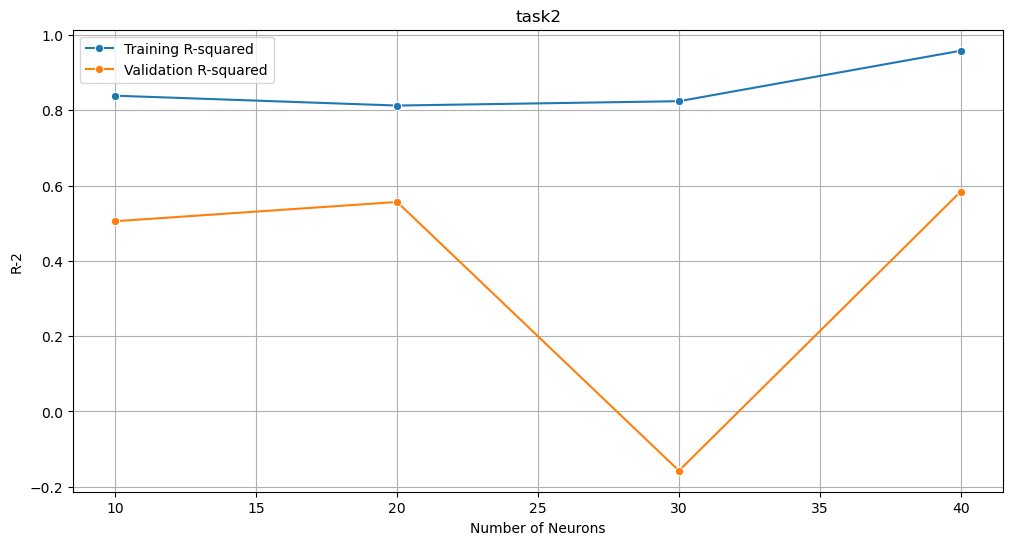

In [60]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=neurons_range,
    y=results_new['mean_train_r2'],
    marker='o',
    label='Training R-squared'
)
sns.lineplot(
    x=neurons_range,
    y=results_new['mean_val_r2'],
    marker='o',
    label='Validation R-squared'
)
plt.xlabel('Number of Neurons')
plt.ylabel('R-2')
plt.title('task2')
plt.legend()
plt.grid(True)
plt.show()

#### as you can see, the overfitting is displayed on the graph after 30 neurons

In [61]:
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MLPRegressor(
        hidden_layer_sizes=(20, 20, 20),
        max_iter=2000,
        early_stopping=True,
        n_iter_no_change=20,
        random_state=0
    ))
])

final_pipeline.fit(X_train, y_train_scaled)

y_pred_scaled_final = final_pipeline.predict(X_test)
y_pred_final = target_scaler.inverse_transform(y_pred_scaled_final.reshape(-1, 1)).ravel()

y_test_original = y_test.values

test_r2_final = r2_score(y_test_original, y_pred_final)
test_mse_final = mean_squared_error(y_test_original, y_pred_final)
print(f"\nFinal R2: {test_r2_final:.4f}")
print(f"MSE: {test_mse_final:.4f}")


Final R2: 0.6375
MSE: 34950124179.1334


#### For some reason, even with scaled data MSE does not work as intended
#### Final R2 score isn't too good too

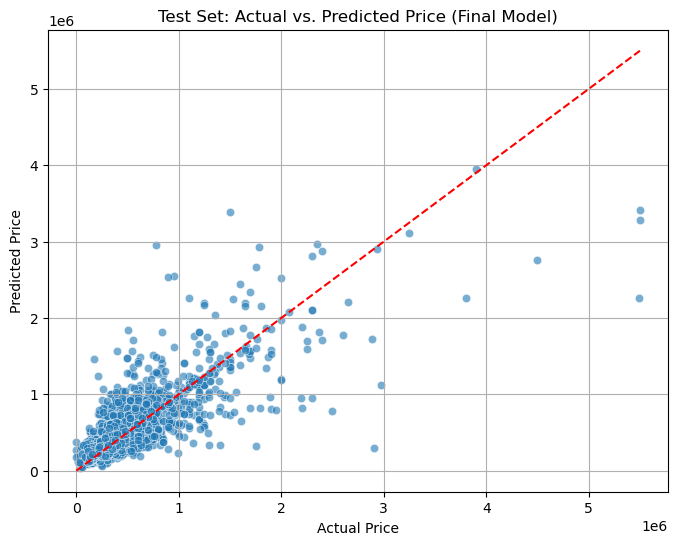

In [62]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original, y=y_pred_final, alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Test Set: Actual vs. Predicted Price (Final Model)')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--')
plt.grid(True)
plt.show()

#### as you can see from this graph, the predicted price finds the line of best fit and tries to guess the actual price.
#### Problem is, too many data points are scattered in a big cloud, which is hard to capture with mlp